In [20]:
######################### This version is meant to be a clone of Dr.Orlandi's version. Using his psych curve etc. goal is to clone behaviour. Will Implement objects.
######################### And then modify from there 
#gonna work in radians

In [21]:
#imports
import numpy as np
import sklearn.model_selection as sk
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as kb  
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import random
from sklearn.decomposition import PCA
from numba import jit
import datetime

In [22]:
#%load_ext tensorboard

In [23]:
class timeSeries:
    '''Class whose objects are times series'''
    
    def __init__(self, series):
        '''Initialization method. Stores an input list'''
        self.tSeries = series

In [24]:
class aTrial:
    '''Objects of this class represent a single trial'''
    
    def __init__(self, inputSeries, desiredOutputSeries, decider, info):
        '''Initialization method. Stores information for one trial
        input Series (timeSeries) is the input time series for a trial. 
        output series (timeSeries) is the output time series for a trial
        info (trialInfo) is information about the trial. '''

        #Store the trial data in the object
        self.inputSeries = inputSeries 
        self.desiredOutputSeries = desiredOutputSeries
        self.decisionAgent = decider
        self.info = info

    def addNetworkResponse(self, response):
        '''adds the networks response to the trial object'''

        #Store the network response in the object
        self.networkResponse = response

In [25]:
class anglePair:
    '''Class whose objects are pairs of angles'''

    def __init__(self, angle1, angle2):
        '''Initialization method stores 2 input angles to the instance'''
        self.angle1 = angle1
        self.angle2 = angle2

In [26]:
class trialInfo:
    '''Class whose objects represent information about a trial'''

    def __init__(self, angSep, angSepBin, pCertain, correctCh, difficultyBin, difficulty, pLeft, pRight, attention):
        #The angle seperation
        self.angSep = angSep
        
        #angSep bin
        self.angSepBin = angSepBin

        #The probability of certainty
        self.pCertain = pCertain

        #The correct choice
        self.correctCh = correctCh

        #The difficulty bin the trial falls into
        self.difficultyBin = difficultyBin

        #The difficulty of the trial
        self.difficulty = difficulty

        #The probability of choosing left
        self.pLeft = pLeft

        #the probability of choosing right
        self.pRight = pRight

        #The attention of the frame
        self.attention = attention

    def addIndex(self, index):
        '''adds the index of the trial inside of the test data trials array'''
        self.index = index

    def addNetworkChoice(self, choice, conclusive):
        '''stores the choice the network made
           stores whether or not the trained network made the right decision on this trial
           wasCorrect is a boolean
           wasConclusive is a boolean''' 
        
        #stores the choice the network made for this trial
        self.netChoice = choice

        #Stores whether or not the network made the correct choice
        self.wasCorrect = (choice == self.correctCh)

        #stores whether or not the two signals separated beyond the tolerance making the decision conclusive
        self.wasConclusive = conclusive
        


In [27]:
class frameInfo:
    '''Class whose objects represent information about a frame in a trial'''

    def __init__(self, angSep, pCertain,correctCh, difficulty, pLeft, pRight, attention):
        #The angle seperation
        self.angSep = angSep

        #The probability of certainty
        self.pCertain = pCertain

        #The correct choice
        self.correctCh = correctCh

        #The difficulty
        self.difficulty = difficulty

        #The probability of choosing left
        self.pLeft = pLeft

        #the probability of choosing right
        self.pRight = pRight

        #The attention of the frame
        self.attention = attention
        


In [28]:
class decisionMaker:
    '''Class that represents the agent making the decision'''

    #This is the desired output from the network when left or right is chosen or no choice is made.
    LEFTCHOICEVAL = 0
    NOCHOICEVAL = 1
    RIGHTCHOICEVAL = 2

    #These are the values that are input to the network that represent high and low attention
    LOWATTVAL = 0
    HIGHATTVAL = 1

    #this is the maximum level of difficulty
    MAXDIFFICULTY = 1


    def __init__(self, attention):
        '''initialization method sets the attention level of the instance'''
        self.attention = attention

    def _sameSign(self, angles):
        '''given a list of two angles the method return True if the angles have same sign. False if the angles have opposite sign'''
        angle1 = angles[0]
        angle2 = angles[1]
        return not abs(angle1 + angle2) < abs(angle1)+abs(angle2)

    def _difficulty1(self, angles):
        '''Given two angles this function returns a difficulty from 0 - 1; 1 being hardest; 0 is easiest'''

        #Variable representing whether or not the angles are the same sign. (Point to the same side ([/ /]->same side) vs ([\ /]->opposite side)
        sameSign = self._sameSign(angles)

        #Find the magnitude of the difference of the angles
        difference = abs( abs(angles[0]) - abs(angles[1]) )

        #slope parameter for steepness of difficulty curve (a function of angle separation)
        beta = 0.05
        #Set the y intercept of the inverse hyperbolic tangent
        if self.attention == decisionMaker.LOWATTVAL:
            alpha = .28 #Alpha is the value of y intercept of the tanh. Also the value of the difficulty of an infinite angle separation. Make it higher for low attention

        elif self.attention == decisionMaker.HIGHATTVAL:
            alpha = 0.1 #Make it lower for high attention

        #offset to shift the graph so at x = 0 arctanh(g(x)) is alpha
        offset = np.arctanh( 2*alpha - 1 )/beta 

        #Scaling Parameter. relates to d(difficulty)/d(angle separation)
        f = .1
        
        if not sameSign: 
            #the angles are not the same side so add a bias to the difficulty
            y = 0  #Parameter that changes difficulty for a given angle separation depending on if they have the same sign [/ /] VS [\ /]
            
            #Shrink f by y 
            f = f - y*f 
        
        #scale it so small differences are large value and big differences are small. Map 0 to inf and inf to zero.                 
        x = 1/(f*difference**2) 

        #Calculate and return difficulty
        dif = 1/2 * ( np.tanh( beta * (x + offset) ) + 1 )

        return dif
    
    def _difficulty2(self, angles):
        '''Given two angles this function returns a difficulty from 0 - 1; 1 being hardest; 0 is easiest'''

        #Variable representing whether or not the angles are the same sign. (Point to the same side ([/ /]->same side) vs ([\ /]->opposite side)
        #sameSign = self._sameSign(angles)

        #Find the magnitude of the difference of the angles
        difference = abs( abs(angles[0]) - abs(angles[1]) )

     
        #b is the difficulty at an angle separation of Q
        if self.attention == decisionMaker.LOWATTVAL:
            b = 0.5

        elif self.attention == decisionMaker.HIGHATTVAL:
            b = 0.3 #Make it lower for high attention

        Q = np.pi/2 #The location that the difficulty is equal to b

        f = -np.log(b)/Q**2
        
        '''if not sameSign: 
            #the angles are not the same side so add a bias to the difficulty
            y = 0  #Parameter that changes difficulty for a given angle separation depending on if they have the same sign [/ /] VS [\ /]
            
            #Shrink f by y 
            g = g - y*g '''
        
        #Calculate and return difficulty
        dif = np.e**(-f*difference**2)

        return dif
    
    def _difficulty3(self, angles):
        '''Given two angles this function returns a difficulty from 0 - 1; 1 being hardest; 0 is easiest'''

        #Variable representing whether or not the angles are the same sign. (Point to the same side ([/ /]->same side) vs ([\ /]->opposite side)
        #sameSign = self._sameSign(angles)

        #Find the magnitude of the difference of the angles
        difference = abs( abs(angles[0]) - abs(angles[1]) )

     
        #1 - b is the value of difficulty at angsep = 0
        if self.attention == decisionMaker.LOWATTVAL:
            b = 0.01

        elif self.attention == decisionMaker.HIGHATTVAL:
            b = 0.1 #Make it higher for high attention

        c = 0.2

        Q = np.pi/2 + c #The location that the difficulty is equal to 0

        f = -np.log(b)/Q**2
        
        '''if not sameSign: 
            #the angles are not the same side so add a bias to the difficulty
            y = 0  #Parameter that changes difficulty for a given angle separation depending on if they have the same sign [/ /] VS [\ /]
            
            #Shrink f by y 
            g = g - y*g '''
        
        #Calculate and return difficulty
        h = np.e**(-f*(difference-Q)**2)

        dif = 1 - h

        return dif
    
    def _difficulty4(self, angles):
        '''Given two angles this function returns a difficulty from 0 - 1; 1 being hardest; 0 is easiest'''

        #Variable representing whether or not the angles are the same sign. (Point to the same side ([/ /]->same side) vs ([\ /]->opposite side)
        #sameSign = self._sameSign(angles)

        #Find the magnitude of the difference of the angles
        difference = abs( abs(angles[0]) - abs(angles[1]) )

        highAttParamVal = 1
        lowAttParamVal = 1.5
     
        #1 - b is the value of difficulty at angsep = 0
        if self.attention == decisionMaker.LOWATTVAL:
            a = lowAttParamVal

        elif self.attention == decisionMaker.HIGHATTVAL:
            a = highAttParamVal #Make it lower for high attention

        c = 1.2

        b = 1/(np.e**(-highAttParamVal*c))
        
        d = 1.1
        
        '''if not sameSign: 
            #the angles are not the same side so add a bias to the difficulty
            y = 0  #Parameter that changes difficulty for a given angle separation depending on if they have the same sign [/ /] VS [\ /]
            
            #Shrink f by y 
            g = g - y*g '''
        
        #Calculate and return difficulty
        dif = b*np.e**(-a*(d*difference+c))

        return dif
    
    def _difficulty(self, angles):
        '''Given two angles this function returns a difficulty from 0 - 1; 1 being hardest; 0 is easiest'''

        #Find the magnitude of the difference of the angles
        difference = abs( abs(angles[0]) - abs(angles[1]) )

        maxAngleNoise = np.pi/640

        #maxAngSep is the angle separation that the difficulty is equal to 
        #maxAngSepDif
        maxAngSep = np.pi/2 - np.pi/ensembleCreator.NUMANGLES + maxAngleNoise
        minAngSep = np.pi/ensembleCreator.NUMANGLES - maxAngleNoise

        minAngSepDifficultyDifference = .25

        maxAngSepDifficultyDifference = .05

        loAttMinAngSepDifficulty = 1
        loAttMaxAngSepDifficulty = .25

       

        #1 - b is the value of difficulty at angsep = 0
        if self.attention == decisionMaker.LOWATTVAL:
            minAngSepDifficulty = loAttMinAngSepDifficulty
            maxAngSepDifficulty = loAttMaxAngSepDifficulty

        elif self.attention == decisionMaker.HIGHATTVAL:
            minAngSepDifficulty = loAttMinAngSepDifficulty - minAngSepDifficultyDifference
            maxAngSepDifficulty = loAttMaxAngSepDifficulty - maxAngSepDifficultyDifference


        b = (maxAngSepDifficulty/minAngSepDifficulty)**(1/(maxAngSep/minAngSep - 1))
        
        a = - np.log(minAngSepDifficulty* b ) * 1/(minAngSep)
        


        #Calculate and return difficulty
        dif = np.e**(-a*abs(difference))*1/b

        if dif >= 1:
            dif = .99

        return dif
    
    def correctChoice(self, angles):
        '''input 2 angles return the smaller angle corresponding to more vertical orientation
        Angle 1 is left angle 2 is right. Returns LEFTCHOICEVAL for Left, RIGHTCHOICEVAL for right
        if they are equal error is thrown because currently only training on non equal angles
        '''
        
        angle1 = angles[0]
        angle2 = angles[1]

        if abs(angle1) < abs(angle2):
            #The left bar is oriented more vertically
            return self.LEFTCHOICEVAL        
            
        elif abs(angle2) < abs(angle1):
            #The right bar is oriented more vertically
            return self.RIGHTCHOICEVAL       
        
        else:
            #throw error if angles are equal
            print("WEHAVEANERROR")
            return -1
        
    def pLeftpRight(self, pCertain, cor):
        #if correct choice is left then chance left is % certainty + .5*(1- % certainty). because val of certainty you are correct and (1-certainty) its a 50/50 guess
            if cor == decisionMaker.LEFTCHOICEVAL:
                pLeftVal = pCertain + .5*(1- pCertain)
                pRightVal = 1 - pLeftVal
                #same as above but right is the correct choice
            elif cor == decisionMaker.RIGHTCHOICEVAL:
                pRightVal = pCertain + .5*(1- pCertain)
                pLeftVal = 1 - pRightVal
                #you have chosen something invalid
            else:
                print("Error!!!!!!!!")
                    
            #Return the prob choose left and prob choose right
            return pLeftVal, pRightVal

        
    def trainedChoice(self, angles, MAXPROB):
        '''Input two angles returns the choice the mouse makes'''

        #store the difficulty
        difficulty = self._difficulty(angles)
        
        #Calculate the probability that the decision maker is certain
        pCertain = self._probablilityCertain(difficulty)
        
        #Check if the probCertain is larger than the maximum allowed certainty
        if pCertain > MAXPROB:
            #If probability certain is larger than the max allowed, then set it to the max
            pCertain = MAXPROB
        
        #Calculate the correct choice. (more vertically oriented)    
        cor = self.correctChoice(angles)

        angDif = ( abs(angles[0]) - abs(angles[1]) ) #angle difference
        
        pLeft, pRight = self.pLeftpRight(pCertain, cor)

        #Store information about the frame in an object
        info = frameInfo(angDif, pCertain, cor, difficulty, pLeft, pRight, self.attention) ####Could change so ang dif and correct get added at creation of info and the info is created in timeseriescreation and passed to decision maker and decider adds the new info to the info 
       
        #Generate a random number in [0,1) and use it to determin whether the decision maker is certain or not
        n = random.random()

        if n < pCertain: #they are certain
            #The decision maker is certain so return the correct answer
            return cor, info
            
        else:#not certain then it is a guess
            #generate a random number in [0,1) to decide which side the decision maker guesses
            g = np.random.random()
            if g < .5:
                #return the correct choice
                choice = cor
                return choice, info
            else:
                #return the other choice
                if cor == decisionMaker.RIGHTCHOICEVAL:
                    choice = decisionMaker.LEFTCHOICEVAL
                    return choice, info
                else:
                    choice = decisionMaker.RIGHTCHOICEVAL
                    return choice, info
                
    def _probablilityCertain(self, difficulty):
        '''return the probability of being certain as a function of difficulty'''
        #difficulty goes from 1 to 0. this flips it and maps a high difficulty to a low probability of being chosen
        p = -difficulty + 1
        return p

In [29]:
class ensembleCreator:
    '''uses the timeSeriesCreator class to create an ensemble of iteration time series'''
    
    #parameters used in the creation of the ensembles

    #the number of angles to be trained on
    NUMANGLES = 8

    #The dimension of the input angles
    ANGLE_DIMENSION = 2

    #The dimension of the input
    INPUT_DIMENSION = 3

    OUTPUT_DIMENSION = 3

    ANGLEMIN = -np.pi/2
    ANGLEMAX = np.pi/2

    ONECHOICE = True

    STIMULUSDURATION = 1.5

    PRESTIMULUSDURATION = 1

    FRAMERATE = 10

    TRIALDURATION = STIMULUSDURATION + PRESTIMULUSDURATION

    TOTALFRAMES = int(round(TRIALDURATION * FRAMERATE, 0))

    STIMULUS_FRAME = int(round(PRESTIMULUSDURATION * FRAMERATE, 0))

    PRESTIMULUSFRAME = STIMULUS_FRAME - 1

    LASTFRAME = TOTALFRAMES - 1

    ATTENTION_LEVELS = [0,1]

    MAXANGSEP = np.pi/2
    
    NUMDIFFBINS = int(round((NUMANGLES-2)/2,0))

    #The offset of the difficulty bins. Where the first bin starts
    DIFFBINOFFSET = 0

    MAXDIFFICULTY = .9999

   # DIFFBINWIDTH = (decisionMaker.MAXDIFFICULTY - DIFFBINOFFSET)/NUMDIFFBINS
    DIFFBINWIDTH = (MAXDIFFICULTY - DIFFBINOFFSET)/NUMDIFFBINS
    NUMANGSEPBINS = int(round((NUMANGLES-2)/2,0))


    ANGBINOFFSET = .2
    ANGSEPBINWIDTH = (MAXANGSEP - ANGBINOFFSET)/NUMANGSEPBINS

    
    
    def __init__(self, MAXPROB, TRIALSPERANGLE):
        self.MAXPROB = MAXPROB
        self.TRIALSPERANGLE = TRIALSPERANGLE
        self.firstEnsemble = True

   
    def addNoise(self, anglePairs):
        '''input a list of left angles and list of right angles and noise is added to them and returned is an array of angle pairs for the ensemble'''
        #extract the left and right angles 
        leftAngles = anglePairs[:, 0]
        rightAngles = anglePairs[:, 1]

        #Variable that scales the noise
        noiseScale = (ensembleCreator.NUMANGLES/np.pi) * 30

        #Add noise to the left and right angles 
        leftAngles += np.random.randn(len(leftAngles)) / noiseScale
        rightAngles += np.random.randn(len(rightAngles)) / noiseScale

        #Reshape the two 1d arrays into one 2d array
        anglePairs = np.column_stack((leftAngles, rightAngles))

        return anglePairs

    def filterSameAngles(self, angle_grid):
        '''input a grid of angles and return list of left and right angles with the abs(angleLeft)!=abs(angleRight)
        filter outt all the angles with same verticallity'''

        #number of decimals to be rounded to when filtering out equal verticality. Due to special operations floating points are not consistent so this is necessary.
        decimals = 2

        #extract the angles
        leftAngles = angle_grid[0].ravel()
        rightAngles = angle_grid[1].ravel()

        #Create the mask
        mask = (np.round(leftAngles, decimals) != np.round(rightAngles, decimals)) & (-np.round(leftAngles, decimals) != np.round(rightAngles, decimals))
       
        #apply the mask
        leftAngles = leftAngles[mask]
        rightAngles = rightAngles[mask]

        #Reshape the two 1d arrays into one 2d array
        anglePairs = np.column_stack((leftAngles, rightAngles)) 

        return anglePairs


    def genAngles(self, Uniform):
        '''This function returns all the angle pairs for one ensemble of trials (One attention level)'''
        #Generate a list of valid angles for one side
        angleList = np.linspace(ensembleCreator.ANGLEMIN, ensembleCreator.ANGLEMAX, ensembleCreator.NUMANGLES)

        #Create a grid of all angle combinations
        angle_grid = np.meshgrid(angleList, angleList)

        #Filter out angles with same verticallity
        anglePairs = self.filterSameAngles(angle_grid)
        
        
        if Uniform:
            angSepDict = {}

            for pair in anglePairs:
                pair = list(pair)

                #angle separation in degrees
                angSep = round(((abs(pair[0]*180/np.pi) - abs(pair[1]*180/np.pi))),4)

                if not (angSepDict.__contains__(angSep)):
                    angSepDict[angSep] = [[pair],1]

                #the angsep exists in dict
                elif  pair not in angSepDict[angSep][0]:
                    angSepDict[angSep][0].append(pair)
                    angSepDict[angSep][1] += 1
                else:
                    angSepDict[angSep][1] += 1

            occurenceList = []  
            for angSep in angSepDict:
                occurenceList.append(angSepDict[angSep][1])
            
            lcm = np.lcm.reduce(occurenceList)
        
            anglePairsCopy = []
        # print(len(anglePairsCopy))
            for pair in anglePairs:
                angSep = round(((abs(pair[0]*180/np.pi) - abs(pair[1]*180/np.pi))),4 )
                multiplesNeeded = int(lcm/angSepDict[angSep][1])
            # print(multiplesNeeded, angSepDict[angSep][1])
                for _ in range((multiplesNeeded)):
                    anglePairsCopy.append(pair)
            
            #print(len(anglePairsCopy))
            anglePairs = np.array(anglePairsCopy)
            
            if self.firstEnsemble:
                self.smallestAngleSeparation = np.min(np.abs(anglePairs[:,0]-anglePairs[:,1]))*180/np.pi
                self.firstEnsemble = False
                
                angSepDict = {}
                for pair in anglePairs:
                    pair = list(pair)
                    angSep = round(((abs(pair[0]*180/np.pi - pair[1]*180/np.pi))),4 )
                    if not (angSepDict.__contains__(angSep)):
                        angSepDict[angSep] = [[pair],1]
                    elif  pair not in angSepDict[angSep][0]:
                        angSepDict[angSep][0].append(pair)
                        angSepDict[angSep][1] += 1
                    else:
                        angSepDict[angSep][1] += 1

                occurenceList = []  
                for angSep in angSepDict:
                    #print(angSep)
                    occurenceList.append(angSepDict[angSep][1])
                #print(occurenceList)
            

        

        

        #Add noise to the angles
        anglePairs = self.addNoise(anglePairs)
        

        #Randomize the order
        np.random.shuffle(anglePairs)

      
        
        return anglePairs
    
    
    def generateEnsemble(self, attention):
        '''Input: An attention level, numBins is number of difficulty levels
           Output: An ensemble of input and output time series corresponding to the input attention level. 
           (The input is what is fed into the network and the output is the desired network response)'''
        
        #generate the angles for the ensemble of trials
        anglePairs = self.genAngles(False)

        #Determine the number of trials 
        numberTrials = len(anglePairs)

        #Instantiate a timeSeriesCreator
        timeSeriesCreator = timeSeriesCreationMachine()

        #Initialize a list to store this ensembles trials
        trialList = np.zeros(numberTrials).astype(aTrial)

        #Go through the trials and for each trial create an input and output time series
        for trial in range(numberTrials):
            #create input time series
            inputTimeSer = timeSeriesCreator.createInputTimeSeries(anglePairs[trial]) 
            
            #initialize a decisionMaker
            decisionAgent = decisionMaker(attention)

            #create output time series
            desiredOutputTimeSer, informat = timeSeriesCreator.createOutputTimeSeries(inputTimeSer, decisionAgent, self.MAXPROB )

            #creare the trial object for this trial
            trialHere = aTrial(inputTimeSer, desiredOutputTimeSer, decisionAgent, informat)
            
            #store the trial data
            trialList[trial] = trialHere

        return trialList
    
    def generateEnsembles(self):
        '''Input: a list of attention levels
           Output: an ensemble of trials at each attention level'''
        
        #Boolean  representing if it is the first attention level. If first then a new list needs to be created. else the existing list should be appended to
        first = True

        #repeat each trial TRIALSPERANGLE times
        for _ in range(self.TRIALSPERANGLE):

            #Counter variable
            c = 0

            #for each attention level create an ensemble of trials
            for attentionLevel in ensembleCreator.ATTENTION_LEVELS:

                #Generate ensemble of trials for this attention level
                trialsData = self.generateEnsemble(attentionLevel)

                #The first time running the list needs to be created
                if first:

                    #Create the list
                    allTrialsData = trialsData

                    #Set first to false
                    first = False

                else:

                    #It is not the first time running so the list exists and it can be appended
                    allTrialsData =  np.concatenate((allTrialsData, trialsData), axis = 0)
                
                #increment the counter
                c +=1

        #Shuffle the list
        np.random.shuffle(allTrialsData)
        
        return allTrialsData

In [30]:
class timeSeriesCreationMachine:
    '''This class has objects that are machines to create time series. it will have configuration options and a method that spits out time series'''
    
    def addNoise(self, inputTimeSeries):
        '''adds noise to an input timeSeries'''
        #Parameter that scales the temporal noise
        temporalNoiseScale = (ensembleCreator.NUMANGLES/np.pi) * 15
       
        #The number of frames
        num_frames = inputTimeSeries.tSeries.shape[0]

        # Generate random noise for each frame
        noise_0 = np.random.randn(num_frames) / temporalNoiseScale
        noise_1 = np.random.randn(num_frames) / temporalNoiseScale

        # Apply noise to the corresponding frames
        inputTimeSeries.tSeries[:, 0] += noise_0
        inputTimeSeries.tSeries[:, 1] += noise_1

        return inputTimeSeries

    def createInputTimeSeries(self, anglePair):                                                                                                                    
        '''Input: ([angle1, angle2], attention)
           Output: timeSeries corresponding to input to network

           generates an input time series for one trial with angles given by angle pair
             '''

        #initialize the list to store the input time series
        inputTimeSeries = timeSeries(np.zeros((ensembleCreator.TOTALFRAMES, ensembleCreator.ANGLE_DIMENSION)).astype(np.float32)) 

        #Add the angles to the series
        inputTimeSeries.tSeries[ensembleCreator.STIMULUS_FRAME:, 0] = anglePair[0]
        inputTimeSeries.tSeries[ensembleCreator.STIMULUS_FRAME:, 1] = anglePair[1]

        #Add noise to the series
        inputTimeSeries = self.addNoise(inputTimeSeries)

        #return the time series
        return inputTimeSeries
    
    def findDifBin(self, value):
        ''' value is the value you want to determine which bin it is in.  '''
        
        #dx is width of bins
        dx = ensembleCreator.DIFFBINWIDTH

        bin = int((value- ensembleCreator.DIFFBINOFFSET) / dx)

        return bin
    
    def findAngSepBin(self, value):
        binWidth = ensembleCreator.ANGSEPBINWIDTH 
        bin = int((abs(value) - ensembleCreator.ANGBINOFFSET)/binWidth)

        return bin
                    
    def createOutputTimeSeries(self, inputTimeSeries, decisionAgent, MAXPROB):
        '''Input: the input time series, attention level, bool that determines if decisionMaker makes multiple choices
           Output: An output time series that is meant to be the desired output of the network when recieving the input time series'''
      
        #Initialize the response time series
        outputTimeSeries = timeSeries(np.full((ensembleCreator.TOTALFRAMES), np.nan)) 

        infoLength = int(round(ensembleCreator.STIMULUSDURATION*ensembleCreator.FRAMERATE,0))

        #angSep is abs(ang1) - abs(ang2)
        angSep = np.zeros(infoLength)
        pCert = np.zeros(infoLength)
        correctCh = np.zeros(infoLength)
        difficulty = np.zeros(infoLength)
        pLeft = np.zeros(infoLength)
        pRight = np.zeros(infoLength)
  
        #Go through frames and create output time series
        for frame in range(ensembleCreator.TOTALFRAMES): 
            if frame < ensembleCreator.PRESTIMULUSFRAME: 
                #The output for preStim frames is nan
                outputTimeSeries.tSeries[frame] = np.nan

            elif frame == ensembleCreator.PRESTIMULUSFRAME:
                #At the preStim frame we want noChoice to be the output
                outputTimeSeries.tSeries[frame] = decisionMaker.NOCHOICEVAL

            elif frame == ensembleCreator.STIMULUS_FRAME:
                #On stim frame make a first decision 
                firstTrainedChoice, frameInformation = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame], MAXPROB)
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
                angSep[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pCertain 
                correctCh[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.correctCh
                difficulty[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.difficulty
                pLeft[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pLeft
                pRight[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pRight
     
            elif ensembleCreator.ONECHOICE == True:
                #We stick with the first decision made at stim presentation
                #No new choices made. each frame we stick with decision made on stim frame
                _, frameInformation = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame], MAXPROB)
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
                angSep[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pCertain
                correctCh[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.correctCh
                difficulty[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.difficulty
                pLeft[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pLeft
                pRight[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pRight
            
            else:
                #continue making choices each frame
                trainedChoice, frameInformation = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame], MAXPROB)
                outputTimeSeries.tSeries[frame] = trainedChoice
                angSep[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pCertain
                correctCh[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.correctCh
                difficulty[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.difficulty
                pLeft[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pLeft
                pRight[frame - ensembleCreator.STIMULUS_FRAME] = frameInformation.pRight
            
        
            
        ####AVERAGE INFO
        angSep = np.average(angSep)
        pCert = np.average(pCert)
        correctCh = np.average(correctCh)
        difficulty = np.average(difficulty)
        pLeft = np.average(pLeft)
        pRight = np.average(pRight)

        angSepBin = self.findAngSepBin(angSep)
        #Determine the difficulty of the trial
        difficultyBin = self.findDifBin(difficulty)

        #Store the trial info
        info = trialInfo(angSep, angSepBin, pCert,correctCh, difficultyBin, difficulty, pLeft, pRight, decisionAgent.attention)


        return outputTimeSeries, info                                                                                                          

In [31]:
class netModel:

    def __init__(self):
        '''initialization method. Initializes instance attributes'''

        #an array of all trials in data set
        self.trialsData = np.nan

        #an array of timeSeries of input to the network for training
        self.inputTrainingData = np.nan

        #an array of timeSeries of input to the network for testing
        self.inputTestData = np.nan

        #an array of timeSeries of desired network output for training
        self.desiredResponseTrainingData = np.nan

        #an array of timeSeries of desired network output for testing
        self.desiredResponseTestData = np.nan

        #an array of difficulty bins for the testing trials
        self.testDifData = np.nan

        #an array of difficulty bins for the training trials
        self.trainDifData = np.nan

        #an array of correct choices for the testing trials
        self.testCorChData = np.nan

        #an array of correct choices for the training trials
        self.trainCorChData = np.nan

        #an array of output from trained network when inputting inputTestingData
        self.testDataNetworkResponse = np.nan

        #the model itself
        self.model = np.nan

        #boolean representing whether the model has been trained or not.
        #used to give an error if requesting test response before network is trained 
        self.isFit = False

    def _custom_loss(self, y_actual,y_pred): 
        '''calculates the loss using the frame immediately before stimulus and last frame of time series
        The frame before stim is to set p left and p right = 0'''

        #Train it to have zero probability of left or right at pre stim frame
        l1 = kb.sparse_categorical_crossentropy(y_actual[:, ensembleCreator.PRESTIMULUSFRAME], y_pred[:, ensembleCreator.PRESTIMULUSFRAME])

        #train it to make the correct choice at the end
        l2 = kb.sparse_categorical_crossentropy(y_actual[:, ensembleCreator.LASTFRAME], y_pred[:, ensembleCreator.LASTFRAME])

        #print(y_actual[:, ensembleCreator.LASTFRAME].numpy())


        custom_loss = l1 + l2

        return custom_loss
        
    def _custom_cat(self, y_actual,y_pred):
        '''Checks the accuracy of the final predicted output and compares it to the desired output'''

        l2 = tf.keras.metrics.sparse_categorical_accuracy(y_actual[:, ensembleCreator.LASTFRAME], y_pred[:, ensembleCreator.LASTFRAME])

        custom_cat = l2
        
        return custom_cat
       
    def genData(self, MAXPROB, TRIALSPERANGLE):
        '''generates and stores the training/testing data for the network'''
        
        #Instantiate an ensemble creator object
        ensembleGen = ensembleCreator(MAXPROB, TRIALSPERANGLE)
        
        #Generate an ensemble of trials for each attention level in the attention list and store the trials in trialsData
        self.trialsData = ensembleGen.generateEnsembles()

    def addAttention(self, trial):
        '''adds attention to the trials input time series
        the time series was two dimensional with second axis having lenght of two [left angle, right angle]
        now it is [left angle, right angle, attention]
         '''

        #generate empty list to store attention series
        att = np.zeros(len(trial.inputSeries.tSeries)).astype(int)

        #Add the data to the empty series
        att += int(trial.decisionAgent.attention)

        #print(att)

        #Add the attention series to the trials time series
        trial.inputSeries.tSeries= np.hstack((trial.inputSeries.tSeries, np.expand_dims(att, axis=1)))

        return trial
        
    def splitData(self):
        '''splits and stores the data into training and test sets'''
       
        if np.isnan(self.trialsData[0].inputSeries.tSeries).any(): #MAKE BETTER
            print("You must generate data before it can be split")

        else:

            #create empty lists to store the trial data to be split intop test and train
            inputTrialsData = np.zeros((len(self.trialsData),ensembleCreator.TOTALFRAMES,ensembleCreator.INPUT_DIMENSION))

            trialsDesiredResponseData = np.zeros((len(self.trialsData), ensembleCreator.TOTALFRAMES))

            trialsDifficultyData = np.zeros(len(self.trialsData))

            trialsCorrectChoiceData = np.zeros(len(self.trialsData))

            trialsData = np.zeros(len(self.trialsData)).astype(aTrial)
            
            #create a counter variable
            c = 0

            #Go through the trials and fill the data lists to be split
            for tri in self.trialsData:
                #add attention to the time series
                tri = self.addAttention(tri)

                #Fill the lists with their information
                inputTrialsData[c] = tri.inputSeries.tSeries
                trialsDesiredResponseData[c] = tri.desiredOutputSeries.tSeries
                trialsDifficultyData[c] = tri.info.difficultyBin
                trialsCorrectChoiceData[c] = tri.info.correctCh
                trialsData[c] = tri

                #increment the counter
                c += 1

            #split the data. test and train
            xTrain, \
            xTest, \
            desiredResponseTrain, \
            desiredResponseTest, \
            difTrain, \
            difTest, \
            corChTrain, \
            corChTest, \
            trainTrials, \
            testTrials = sk.train_test_split(
                                                            inputTrialsData, 
                                                            trialsDesiredResponseData,
                                                            trialsDifficultyData, 
                                                            trialsCorrectChoiceData,
                                                            trialsData,
                                                            test_size=0.25, 
                                                            random_state=None
                                                            )
            
            #Store the data
            self.inputTestData = xTest
            self.inputTrainingData = xTrain
            self.desiredResponseTestData = desiredResponseTest
            self.desiredResponseTrainingData = desiredResponseTrain
            self.testDifData = difTest
            self.trainDifData = difTrain
            self.testCorChData = corChTest
            self.trainCorChData = corChTrain
            self.testTrials = testTrials
            self.trainTrials = trainTrials

    def genModel(self, UNITS):
        '''creates and stores the model'''

        #ensure data is generated and split
        if np.isnan(self.inputTestData).any():
            print("Please generate and split your data before creating the model")
        else:
            #initialize the model
            self.UNITS = UNITS

            model = keras.models.Sequential()

            #add the input layer
            model.add(
                        Input(
                                shape = (
                                            ensembleCreator.TOTALFRAMES, 
                                            ensembleCreator.INPUT_DIMENSION
                                            )
                                )
                        )
            
            #add the rnn layer
            model.add(layers.SimpleRNN(UNITS, activation = 'tanh', return_sequences = True, name = 'rnn'))

            #add the normalization layer
            model.add(layers.BatchNormalization(name = 'batch_norm'))

            #add the softmax layer
            model.add(layers.Dense(ensembleCreator.OUTPUT_DIMENSION, activation = 'softmax', name = 'outputprobs'))

            #create metrics
            metrr = ['accuracy', self._custom_cat]
            
            #compile the model
            model.compile(
                            loss=self._custom_loss,
                            optimizer="adam",
                            metrics=metrr
                            )
            
            log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


            #store the model in the object
            self.model = model

    def trainModel(self, MAX_EPOCHS, BATCH_SIZE):
        '''trains the model using generated training data'''
        if np.equal(self.model, np.nan):
            "Please create the model before you can train it"
        else:
            self.modelHistory = self.model.fit(
                                self.inputTrainingData, 
                                self.desiredResponseTrainingData, 
                                epochs = MAX_EPOCHS, 
                                batch_size = BATCH_SIZE, 
                                verbose = True, 
                                validation_data = (
                                                    self.inputTestData, 
                                                    self.desiredResponseTestData
                                                    ),
                                callbacks = [self.tensorboard_callback]
                                )
            self.isFit = True
            
    def genTestOutput(self):
        '''generates a test output from test input once model is trained'''
        if self.isFit:
            self.testDataNetworkResponse = self.model.predict(self.inputTestData)
        else:
            print("Please create and train the model first")

    def buildModel(self, MAXPROB , UNITS, MAX_EPOCHS, BATCH_SIZE, TRIALSPERANGLE):

        self.genData(MAXPROB, TRIALSPERANGLE) 

        self.splitData()

        self.genModel(UNITS)

        self.trainModel(MAX_EPOCHS, BATCH_SIZE)


In [32]:
class analyser:

    def __init__(self, run):

        self.pcaShaped = np.nan
        self.pca = np.nan

        self.run = run

    
    
    
    
    def plotPsychCurve(self):
        '''plots the predicted and actual psych curves'''

        #create subplots for graphing data
        fig, ax = plt.subplots(6,1, sharex = False,sharey = False, figsize = (10,10))

        #list to store angle differences
        angDifference = []

        #list to store probabilty of choosing left as a function of angle difference
        pLeft = []

        #list to store probabilty of choosing right as a function of angle difference
        pRight = []

        trialDiff = []

        #list to store abs(angle differences)
        absAngDifference = []
        
        #Create lists for histogram data
        probRightListHighAttSameSignCorrect = []
        probRightListLowAttSameSignCorrect = []
        probRightListHighAttOppSignCorrect = []
        probRightListLowAttOppSignCorrect = []

        probLeftListHighAttSameSignCorrect = []
        probLeftListLowAttSameSignCorrect = []
        probLeftListHighAttOppSignCorrect = []
        probLeftListLowAttOppSignCorrect = []

        probRightListHighAttSameSignInCorrect = []
        probRightListLowAttSameSignInCorrect = []
        probRightListHighAttOppSignInCorrect = []
        probRightListLowAttOppSignInCorrect = []

        probLeftListHighAttSameSignInCorrect = []
        probLeftListLowAttSameSignInCorrect = []
        probLeftListHighAttOppSignInCorrect = []
        probLeftListLowAttOppSignInCorrect = []
        

        highAttSameSignAngListRight = []
        lowAttSameSignAngListRight = []
        highAttOppSignAngListRight = []
        lowAttOppSignAngListRight = []
        highAttSameSignAngListLeft = []
        lowAttSameSignAngListLeft = []
        highAttOppSignAngListLeft = []
        lowAttOppSignAngListLeft = []
        
        #counter variable
        counter = 0

        #Boolean representing if angles are equal sign
        SameSign = True
 

        #go through the output data and create normalized histograms
        for response in self.run.mod.desiredResponseTestData:
            #go through trials and store probability of choosing left and right based on certainty and the correct choice
            trialNow = self.run.mod.trialsData[counter]
            angDif = trialNow.info.angSep
            pLeftVal = trialNow.info.pLeft
            pRightVal = trialNow.info.pRight
            diff = trialNow.info.difficulty

            angDifference.append(angDif) #angDif
            absAngDifference.append(abs(angDif)) #angDif
            trialDiff.append(diff)
            pLeft.append(pLeftVal)
            pRight.append(pRightVal)



            #Empty list to store trial info
            trialList = []

            #Variable to store how many times left was chosen
            leftCount = 0 

            #variable to store how many times right was chosen
            rightCount = 0       
            
            #Go through choices made during stimulus duration
            for frame in response:
                #ensure the frame is a stimulus frame
                if ( (not(np.isnan(frame))) & (not(float(frame) == 1.0))):
                    trialList.append(frame)
                    if frame == decisionMaker.LEFTCHOICEVAL:
                        leftCount += 1
                    else:
                        rightCount += 1

            numDecision = len(trialList)# num frames
   
            #find probabilities from data
            probLeft = leftCount/numDecision
            probRight = rightCount/numDecision

            #store the angles and the difference of their abs values
            angle1 = self.run.mod.inputTestData[counter][ensembleCreator.STIMULUS_FRAME][0]
            angle2 = self.run.mod.inputTestData[counter][ensembleCreator.STIMULUS_FRAME][1]
            angleDif = (abs(angle1) - abs(angle2))

            #store the attention level
            attent = self.run.mod.inputTestData[counter][ensembleCreator.STIMULUS_FRAME][2]

            #check if the angles have same sign
            SameSign = not abs(angle1 + angle2) < abs(angle1)+abs(angle2)
            
            #decide what is the correct choice
            left = abs(angle1)<abs(angle2) 

            #decide which curve the data belongs to 
            if attent == decisionMaker.LOWATTVAL:#low Attention
                if SameSign:#Same sign
                    if left:
                        probLeftListLowAttSameSignCorrect.append(probLeft)
                        probRightListLowAttSameSignInCorrect.append(probRight)
                        lowAttSameSignAngListLeft.append(angleDif)
                    else:
                        probLeftListLowAttSameSignInCorrect.append(probLeft)
                        probRightListLowAttSameSignCorrect.append(probRight)
                        lowAttSameSignAngListRight.append(angleDif)

                else:#opp sign
                    if left:
                        probLeftListLowAttOppSignCorrect.append(probLeft)
                        probRightListLowAttOppSignInCorrect.append(probRight)
                        lowAttOppSignAngListLeft.append(angleDif)
                    else:
                        probLeftListLowAttOppSignInCorrect.append(probLeft)
                        probRightListLowAttOppSignCorrect.append(probRight)
                        lowAttOppSignAngListRight.append(angleDif)
            
            elif attent == decisionMaker.HIGHATTVAL: #High attention
                if SameSign:  #same sign
                    if left:
                        probLeftListHighAttSameSignCorrect.append(probLeft)
                        probRightListHighAttSameSignInCorrect.append(probRight)
                        highAttSameSignAngListLeft.append(angleDif)
                    else:
                        probLeftListHighAttSameSignInCorrect.append(probLeft)
                        probRightListHighAttSameSignCorrect.append(probRight)
                        highAttSameSignAngListRight.append(angleDif)

                else: #opp sign
                    if left:
                        probLeftListHighAttOppSignCorrect.append(probLeft)
                        probRightListHighAttOppSignInCorrect.append(probRight)
                        highAttOppSignAngListLeft.append(angleDif)

                    else:
                        probLeftListHighAttOppSignInCorrect.append(probLeft)
                        probRightListHighAttOppSignCorrect.append(probRight)
                        highAttOppSignAngListRight.append(angleDif)


            #increment counter
            counter += 1

         #set titles
        ax[0].set_title("prob left predict")
        ax[1].set_title("prob right predict")
   
        #plot p left and p right
        ax[0].plot(angDifference,pLeft, 'or', markersize = 0.3)
        ax[1].plot(angDifference,pRight, 'ob', markersize = 0.3)
        ax[2].plot(absAngDifference,trialDiff, 'og', markersize = 0.4)
        ax[3].hist(trialDiff, 100)
        ax[4].hist(angDifference, 100)
        c = 0
        for i in pRight:
            if i < .5:
                pRight[c] = 1-i
           
            c+=1
        
        ax[5].plot(abs(np.array(angDifference)), pRight, 'or', markersize = 0.3)

        line = np.linspace(0, 5000, 100)
        const = 0*line + 1
        for u in range(ensembleCreator.NUMDIFFBINS+1):
            ax[3].plot(u*(ensembleCreator.DIFFBINWIDTH)*const + ensembleCreator.DIFFBINOFFSET, line, 'r')
        
        for u in range(ensembleCreator.NUMANGSEPBINS+1):
            ax[4].plot(u*(ensembleCreator.ANGSEPBINWIDTH)*const + ensembleCreator.ANGBINOFFSET, line, 'r')
        

        #create the normalized histograms 
        hist1 = self.binner(highAttSameSignAngListRight,probRightListHighAttSameSignCorrect, 0 , np.pi/2 )
        hist2 = self.binner(highAttSameSignAngListLeft,probRightListHighAttSameSignInCorrect, -np.pi/2 , 0 )

        hist3 = self.binner(lowAttSameSignAngListRight,probRightListLowAttSameSignCorrect, 0 , np.pi/2 )
        hist4 = self.binner(lowAttSameSignAngListLeft,probRightListLowAttSameSignInCorrect, -np.pi/2 , 0  )

        hist5 = self.binner(highAttOppSignAngListRight,probRightListHighAttOppSignCorrect, 0 , np.pi/2 )
        hist6 = self.binner(highAttOppSignAngListLeft,probRightListHighAttOppSignInCorrect, -np.pi/2 , 0 )

        hist7 = self.binner(lowAttOppSignAngListRight,probRightListLowAttOppSignCorrect, 0 , np.pi/2 )
        hist8 = self.binner(lowAttOppSignAngListLeft,probRightListLowAttOppSignInCorrect, -np.pi/2 , 0  )

        hist9 = self.binner(highAttSameSignAngListLeft,probLeftListHighAttSameSignCorrect, -np.pi/2 , 0  )
        hist10 = self.binner(highAttSameSignAngListRight,probLeftListHighAttSameSignInCorrect, 0 , np.pi/2 )

        hist11 = self.binner(lowAttSameSignAngListLeft,probLeftListLowAttSameSignCorrect, -np.pi/2 , 0 )
        hist12 = self.binner(lowAttSameSignAngListRight,probLeftListLowAttSameSignInCorrect, 0 , np.pi/2 )

        hist13 = self.binner(highAttOppSignAngListLeft,probLeftListHighAttOppSignCorrect, -np.pi/2 , 0 )
        hist14 = self.binner(highAttOppSignAngListRight,probLeftListHighAttOppSignInCorrect, 0 , np.pi/2 )

        hist15 = self.binner(lowAttOppSignAngListLeft,probLeftListLowAttOppSignCorrect, -np.pi/2 , 0  )
        hist16 = self.binner(lowAttOppSignAngListRight,probLeftListLowAttOppSignInCorrect, 0 , np.pi/2 )

        histList1 = [hist1,hist2,hist3,hist4,hist5,hist6,hist7,hist8]
        histList2 = [hist9,hist10,hist11,hist12,hist13, hist14, hist15, hist16]

        #plot the histograms
        for hist in histList1:
            for i in hist:
                if i[1]>0:
                    ax[1].plot(i[0],i[1], 'or', markersize = 1.5)
        for hist in histList2:
            for i in hist:
                if i[1]>0:
                    ax[0].plot(i[0],i[1], 'ob', markersize = 1.5)     
        
        fig.tight_layout(pad=1.0)

        #show the plot
        plt.show()


    def binner(self,angleList, probList, start, stop):
        '''Input: A list of angleDifferences, a list of probabilities corresponding to the angle differences'''
        #Noise is added to the angles so some will be slightly above pi/2 and some below -pi/2. this error term acounts for that by increasing interval
        #errScale = 25
        #err = (stop - start)/errScale
        err = np.pi/16
        #specify the number of bins
        numBins = 100
        numPoints = numBins + 1

        #create a space for the bins
        bins = np.linspace(start- err, stop + err, numPoints)

        #initialize the histogram. [location, avgProb]
        hist = np.zeros((numBins,2))

        #determine size of each bin
        ranger = bins[1] - bins[0]

        #increment to the middle of bin
        dx = ranger/2

        #Where to start histo from
        spot = start

        #for each bin create its normalized count
        for i in range(len(bins)):
            if i < len(bins)-1  :
                loc = spot + dx 
                hist[i][0] = loc
                count = 0
                totP = 0
                for j in range(len(probList)):
                    if (angleList[j] < spot + ranger) & (angleList[j]>= spot):
                        count += 1
                        totP += probList[j]
                if count != 0:
                    avgP = totP/count
                else:
                    avgP = 0
                hist[i][1] = avgP
                spot += ranger
        return hist  
        

    def analyseNetworkResponse(self):
        '''Goes through the trained networks response to the inputTestData and returns '''
        wrongCount = 0
        inconclusiveCount = 0

        tolerance = 0.1

        index = 0
        for trialResponse in self.run.mod.testDataNetworkResponse:
            sep = trialResponse[ensembleCreator.LASTFRAME][0] - trialResponse[ensembleCreator.LASTFRAME][2]
            if (sep) >= 0:

                networkChoice = decisionMaker.LEFTCHOICEVAL

                if abs(sep) >= tolerance:
                    conclusive = True

                else:
                    conclusive = False
                    inconclusiveCount += 1

            else:

                networkChoice = decisionMaker.RIGHTCHOICEVAL

                if abs(sep) >= tolerance:
                    conclusive = True
                else:
                    conclusive = False
                    inconclusiveCount += 1

            if networkChoice != self.run.mod.testTrials[index].info.correctCh:
                wrongCount += 1
            
                
            self.run.mod.testTrials[index].addNetworkResponse(trialResponse)
            self.run.mod.testTrials[index].info.addNetworkChoice(networkChoice, conclusive)

            index += 1

        print(round(wrongCount/len(self.run.mod.testTrials)*100,4) , "% of trials the wrong choice was made")

        print(round(inconclusiveCount/len(self.run.mod.testTrials)*100,4) , "% of trials no distinct choice was made")

    
    def sortTrials(self):
        '''This method sorts the test trials by type'''

        #correct vs incorrect network choice
        self.correct = []
        self.incorrect = []
        
        #conclusive vs  inconclusive network choice
        self.conclusive = []
        self.inconclusive = []

        #High vs low attention trials
        self.highAttTrials = []
        self.lowAttTrials = []

        #left was correct vs right was correct
        self.leftCorrectCh = []
        self.rightCorrectCh = []

        #easy medium and hard trials
        self.difTrials = []

        self.angSepBins = []

        for _ in range(ensembleCreator.NUMANGSEPBINS):
            self.angSepBins.append([])

        for _ in range(ensembleCreator.NUMDIFFBINS):
            self.difTrials.append([])

        index = 0
        for trial in self.run.mod.testTrials:

            trial.info.addIndex(index)

            if trial.info.attention == decisionMaker.LOWATTVAL:
                self.lowAttTrials.append(trial)
                
            elif trial.info.attention == decisionMaker.HIGHATTVAL:
                self.highAttTrials.append(trial)
                
            else:
                print("error")
            
            self.difTrials[trial.info.difficultyBin].append(trial)
      
            self.angSepBins[trial.info.angSepBin].append(trial)

            if trial.info.correctCh == decisionMaker.RIGHTCHOICEVAL:
                self.rightCorrectCh.append(trial)

            elif trial.info.correctCh == decisionMaker.LEFTCHOICEVAL:
                self.leftCorrectCh.append(trial)

            else:
                print("error")

            if trial.info.wasCorrect:
                self.correct.append(trial)
            else:
                self.incorrect.append(trial)

            if trial.info.wasConclusive:
                self.conclusive.append(trial)
            else:
                self.inconclusive.append(trial)

            index += 1


    def plotTestResponse(self, average):
        '''plots a sample of test responses for low and high attention'''
        
        fig, ax = plt.subplots(2, len(self.angSepBins), sharex= True, sharey= True)

        c = len(self.angSepBins) - 1
        for thisAngSep in self.angSepBins:
            lowAtt = self.intersection(self.intersection(self.intersection(self.lowAttTrials, thisAngSep), self.rightCorrectCh), self.correct)
            highAtt = self.intersection(self.intersection(self.intersection(self.highAttTrials, thisAngSep), self.rightCorrectCh),self.correct)

            if average:
                lowAttAvg = -1
                for lowAttTrial in lowAtt:
                    if type(lowAttAvg) == int:
                        lowAttAvg = lowAttTrial.networkResponse
                    else:
                        lowAttAvg += lowAttTrial.networkResponse
                lowAttAvg = lowAttAvg/len(lowAtt)

                highAttAvg = -1
                for highAttTrial in highAtt:
                    if type(highAttAvg) == int:
                        highAttAvg = highAttTrial.networkResponse
                    else:
                        highAttAvg += highAttTrial.networkResponse
                highAttAvg = highAttAvg/len(highAtt)

                ax[0][c].plot(highAttAvg)
                ax[1][c].plot(lowAttAvg)
            else:
                lowIndex = np.random.randint(0, len(lowAtt)-1)
                highIndex = np.random.randint(0, len(highAtt)-1)
            

                ax[1][c].plot(self.run.mod.testDataNetworkResponse[lowIndex])
                ax[0][c].plot(self.run.mod.testDataNetworkResponse[highIndex])
            c-= 1

        ax[0][0].set_title("High Attention")
        ax[1][0].set_title("Low Attention")
        fig.tight_layout(pad=1.0)
        plt.show()


    def PCA_avg(self, filteredList):
        '''filtered list is a list of trials of a specific type
            the indexes of those trials are used and averaged over the pca'''
        if np.isnan(self.pcaShaped).any():
            print("error. Create the shaped PCA array first")
            
            return np.array([])
        else:

            first = True
            count = 0
            avgList = np.nan
            entireList = []
            for t in filteredList:
                entireList.append(self.pcaShaped[t.info.index].copy())
                if first:
                    avgList = self.pcaShaped[t.info.index].copy()
                    first = False
                else:
                    avgList += self.pcaShaped[t.info.index].copy()
                count += 1
            
            avgList = avgList/count
            
            stdDev = []
            for time in range(ensembleCreator.TOTALFRAMES):
                stdDev.append([])
                for dimension in range(UNITS):
                    stdDevHere = (np.std(entireList[:][dimension][time]))
                    stdDev[time].append(stdDevHere)

            
            print(stdDev)

            return avgList, stdDev
    

    def createPCAArray(self):
        '''maybe move this to netModel'''
        rnn_layer_output = keras.Model(inputs= self.run.mod.model.inputs, outputs=self.run.mod.model.get_layer('rnn').output)

        # Get rnn layer activations for input data
        rnn_activations = rnn_layer_output.predict(self.run.mod.inputTestData)

        flat = rnn_activations.reshape(-1, rnn_activations.shape[-1])

        pca = PCA(n_components= self.run.mod.UNITS)  # Choose the number of components as needed

        pca_result = pca.fit_transform(flat)

        self.pca = pca

        self.pcaShaped = pca_result.reshape((len(self.run.mod.inputTestData), ensembleCreator.TOTALFRAMES, self.run.mod.UNITS))

    def plotExplainedVariance(self):
        if not isinstance(self.pca, PCA):
            print("error generate pca first")
        else:
            explainedVarRatio = np.array(self.pca.explained_variance_ratio_)
            listToPlot = []

            sum = 0
            for ratio in explainedVarRatio:
                sum += ratio
                listToPlot.append(sum)

            plt.plot(listToPlot[:10], 'ro')
            plt.title("Total Explained Variance vs pca component")
            plt.xlabel("PCA Component")
            plt.ylabel("sum of variance explained")
            plt.show()
            

    def intersection(self, list1, list2):
        '''returns the intersection of list1 and list2'''
        intersect = list(set(list1.copy()).intersection(set(list2.copy())))
        return intersect
    
    def plotWithError(self,timeSeries, err, ax, start, end, col):
        for i in range(end - start):
            ax.plot(range(25),timeSeries[:,start + i],color = col)
            ax.fill_between(range(25), timeSeries[:,start + i] - err, timeSeries[:,start + i] + err, color = col, alpha = 0.1)
            

    def stateVectorCreation(self, avg_pca1_zScored, avg_pca2_zScored):
        last1 = np.array(avg_pca1_zScored[-1,:])
        last2 = np.array(avg_pca2_zScored[-1,:])
        
        difV = last2-last1

        difV = difV/np.linalg.norm(difV)

        return difV


In [33]:
class main1:

    
    def __init__(self, MAXPROB , UNITS, MAX_EPOCHS, BATCH_SIZE, TRIALSPERANGLE):
        '''Trains network and plots test output'''
        self.mod = netModel()

        self.mod.genData(MAXPROB, TRIALSPERANGLE) 

        self.mod.splitData()

        self.mod.genModel(UNITS)

        self.mod.trainModel(MAX_EPOCHS, BATCH_SIZE)

        self.mod.genTestOutput()

        


In [34]:
class networkBuilder:

    def __init__(self, MAXPROB , UNITS, MAX_EPOCHS, BATCH_SIZE, TRIALSPERANGLE):
        '''Trains network and plots test output'''
        
        self.mod = netModel()

        self.mod.buildModel(MAXPROB , UNITS, MAX_EPOCHS, BATCH_SIZE, TRIALSPERANGLE)

        self.mod.genTestOutput()
       

In [35]:
MAXPROB = .9

UNITS = 256 # Number of neurons in the dense layer

MAX_EPOCHS = 60 # Total epochs

BATCH_SIZE = 80000 # Trials per batch

TRIALSPERANGLE = 1000 #Trials per angle

In [36]:
'''unitList = [400, 350, 300, 256, 200, 128, 64, 40, 30, 20, 10, 8, 6, 4, 3, 2, 1]


trialList = [1000, 800, 500]

dictList = []


for trialsHere in trialList:
    finalAccuracyList = {}
    for UNITS_Used in unitList:
        run = networkBuilder(MAXPROB, UNITS_Used, MAX_EPOCHS, BATCH_SIZE, trialsHere)
        finalAccuracyList[UNITS_Used] = run.mod.modelHistory.history["val__custom_cat"][-1]
    dictList.append(finalAccuracyList)
        '''

'unitList = [400, 350, 300, 256, 200, 128, 64, 40, 30, 20, 10, 8, 6, 4, 3, 2, 1]\n\n\ntrialList = [1000, 800, 500]\n\ndictList = []\n\n\nfor trialsHere in trialList:\n    finalAccuracyList = {}\n    for UNITS_Used in unitList:\n        run = networkBuilder(MAXPROB, UNITS_Used, MAX_EPOCHS, BATCH_SIZE, trialsHere)\n        finalAccuracyList[UNITS_Used] = run.mod.modelHistory.history["val__custom_cat"][-1]\n    dictList.append(finalAccuracyList)\n        '

In [37]:
#finalAccuracyList

In [38]:
'''colorList = ['ro','go','bo']
i = 0
for color in colorList:
    plt.plot(dictList[i].keys(), dictList[i].values(), color)
    i+=1
plt.title("Final Accuracy vs Number of Units")
plt.xlabel("Units")
plt.ylabel("Final Accuracy")
plt.show()'''#

'colorList = [\'ro\',\'go\',\'bo\']\ni = 0\nfor color in colorList:\n    plt.plot(dictList[i].keys(), dictList[i].values(), color)\n    i+=1\nplt.title("Final Accuracy vs Number of Units")\nplt.xlabel("Units")\nplt.ylabel("Final Accuracy")\nplt.show()'

In [39]:
run = networkBuilder(MAXPROB, 100, MAX_EPOCHS, BATCH_SIZE, 1000)

2024-08-13 12:13:27.631991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 12:13:27.665500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 12:13:27.667316: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/60


I0000 00:00:1723572808.855523  464381 service.cc:145] XLA service 0x7d6c08004580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723572808.855548  464381 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-08-13 12:13:28.875578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-13 12:13:28.962272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - _custom_cat: 0.4369 - accuracy: 0.2527 - loss: 3.4781

I0000 00:00:1723572809.777562  464381 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - _custom_cat: 0.4369 - accuracy: 0.2527 - loss: 3.4781 - val__custom_cat: 0.2643 - val_accuracy: 0.1836 - val_loss: 2.0771
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - _custom_cat: 0.4067 - accuracy: 0.2389 - loss: 2.3756 - val__custom_cat: 0.1889 - val_accuracy: 0.1646 - val_loss: 2.0056
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - _custom_cat: 0.4514 - accuracy: 0.2475 - loss: 1.8537 - val__custom_cat: 0.2877 - val_accuracy: 0.1833 - val_loss: 1.9630
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - _custom_cat: 0.4702 - accuracy: 0.2760 - loss: 1.7623 - val__custom_cat: 0.3790 - val_accuracy: 0.2070 - val_loss: 1.9236
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - _custom_cat: 0.4703 - accuracy: 0.2872 - loss: 1.6597 - val__custom_cat: 0.3761 - val_accuracy: 0.2184 - val_loss: 1.8787
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - _custom_cat: 0.4459 - accuracy: 0.2832 - loss: 1.5184 - val__custom_cat: 0.3865 - val_accura

(array([12036.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11964.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

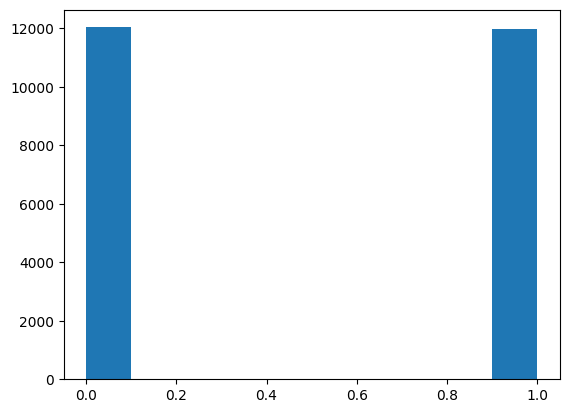

In [40]:
plt.hist(np.argmax(np.abs(run.mod.inputTestData[:,-1,0:2]),-1))
#invalidTrials = np.where(np.argmax(np.abs(run.mod.inputTestData[:,-1,:]),-1)==2)
#print(invalidTrials[0][2])
#plt.plot(run.mod.inputTestData[invalidTrials[0][2],:,:])

In [41]:
#run.mod.modelHistory.history["val__custom_cat"][-1]

In [42]:
#%tensorboard --logdir logs/fit

In [43]:
see = analyser(run)

In [44]:
counter = 0
fullDiff = []
for response in see.run.mod.desiredResponseTestData:
    #go through trials and store probability of choosing left and right based on certainty and the correct choice
    trialNow = see.run.mod.trialsData[counter]
    angDif = trialNow.info.angSep
    pLeftVal = trialNow.info.pLeft
    pRightVal = trialNow.info.pRight
    diff = trialNow.info.difficulty
    fullDiff.append(diff)
    counter += 1

(array([3129.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2866.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

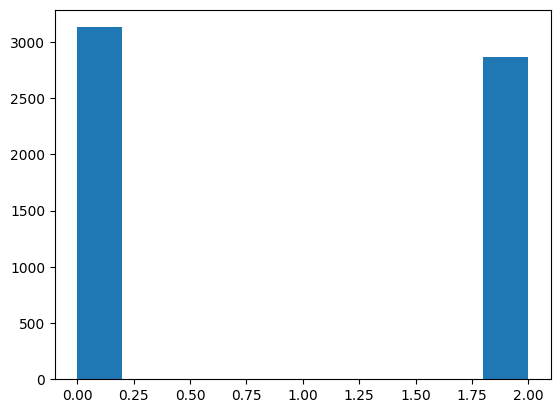

In [57]:
fullDiff = np.array(fullDiff)
easyTrials = np.where(fullDiff>0.8)
list(easyTrials)
plt.hist(np.argmax(run.mod.testDataNetworkResponse[easyTrials[0],-1,:],-1))

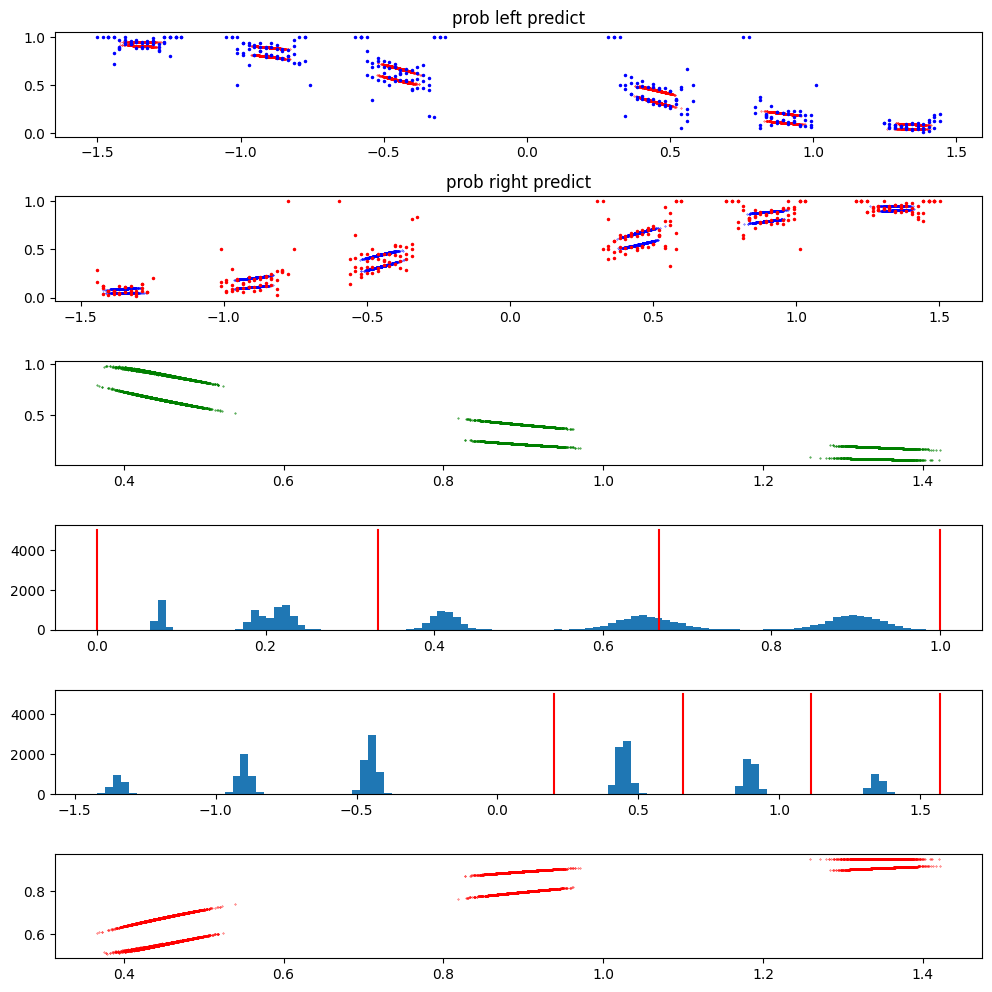

In [46]:
see.plotPsychCurve()

In [47]:
see.analyseNetworkResponse()

1.8042 % of trials the wrong choice was made
13.2917 % of trials no distinct choice was made


In [48]:
see.sortTrials()

In [49]:
len(see.rightCorrectCh)


12036

In [50]:
len(see.leftCorrectCh)
print(25000-12077-11923)

1000


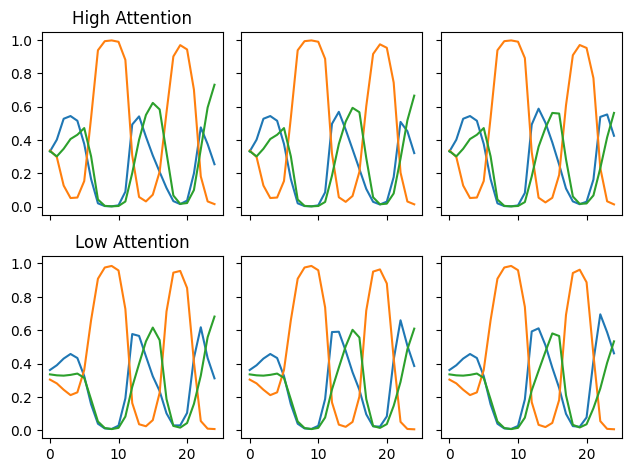

In [51]:
see.plotTestResponse(True)

In [52]:
see.createPCAArray()

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


In [53]:
leftChoiceCorrect = see.intersection(see.correct, see.leftCorrectCh)

leftChoiceIncorrect = see.intersection(see.incorrect, see.leftCorrectCh)

rightChoiceCorrect = see.intersection(see.correct, see.rightCorrectCh)

rightChoiceIncorrect = see.intersection(see.incorrect, see.rightCorrectCh)

highAttCorrect = see.intersection(see.correct, see.highAttTrials)

lowAttCorrect = see.intersection(see.correct, see.lowAttTrials)

In [54]:
lCorHard, stdDev1 = see.PCA_avg(see.intersection(rightChoiceCorrect, see.angSepBins[0]))
rCorHard, std2 = see.PCA_avg(see.intersection(leftChoiceCorrect, see.angSepBins[0]))

see.stateVectorCreation(lCorHard, rCorHard)

[[0.14533487, 0.16154477, 0.14510451, 0.16113487, 0.14513779, 0.16043957, 0.1451831, 0.14503251, 0.16075258, 0.14594346, 0.14518549, 0.14480823, 0.14522688, 0.14509739, 0.16072164, 0.14496432, 0.14486155, 0.16106391, 0.16057043, 0.16081648, 0.1454232, 0.14499664, 0.14545749, 0.1450148, 0.1453215, 0.16270582, 0.14503446, 0.14514747, 0.14507142, 0.14529559, 0.1450599, 0.16061555, 0.16126578, 0.14577273, 0.16098633, 0.14536417, 0.1448405, 0.14483316, 0.14503716, 0.16170757, 0.16145647, 0.14490126, 0.14542323, 0.14518839, 0.1457049, 0.1615112, 0.16091378, 0.16038221, 0.14531603, 0.1450038, 0.1450709, 0.14505209, 0.14510089, 0.14510602, 0.16103964, 0.14502262, 0.14524733, 0.14511725, 0.16074982, 0.14519769, 0.1452013, 0.16066718, 0.1613445, 0.14535682, 0.1610209, 0.16098294, 0.16087979, 0.14508784, 0.16127585, 0.14480089, 0.14548013, 0.14483386, 0.16159375, 0.16078591, 0.14573756, 0.16040035, 0.14499028, 0.1452987, 0.16091093, 0.16106111, 0.14506501, 0.14520895, 0.14534305, 0.16115178, 0.16

array([ 2.9639068e-01, -2.2458033e-01,  7.5980432e-02,  4.0483722e-01,
       -3.8778711e-02, -1.0172540e-01,  6.1172787e-02, -2.2029552e-01,
       -2.7203593e-01, -2.6619352e-02, -4.3470788e-01, -5.8878489e-02,
        2.2929770e-01, -1.0256234e-01,  1.0348729e-01,  2.1386677e-01,
        7.0684031e-02,  7.3315203e-02,  2.7356980e-02, -4.5237701e-02,
       -2.0897932e-01,  2.4651845e-01, -5.0832354e-02, -2.1324966e-02,
       -1.1607739e-01, -1.5507832e-01, -6.3031152e-02, -6.4181373e-02,
        1.1111055e-01, -4.3740846e-02, -9.0329507e-03,  5.9306417e-02,
        1.9762233e-02, -7.9583470e-03,  2.6786418e-03,  6.5905400e-02,
        2.9645337e-02, -7.0483334e-02,  3.9658914e-04,  1.1561853e-01,
        1.2621343e-02, -4.2906005e-02, -7.8956438e-03,  7.2790861e-02,
       -1.4194240e-02, -7.0325032e-02,  6.2192394e-03, -3.2952942e-02,
        2.9679187e-02,  2.5762690e-02, -9.2040673e-03,  9.4566676e-05,
       -2.1997582e-02, -2.1706289e-02, -7.9466820e-02, -3.6426254e-03,
      

[[0.14533487, 0.16154477, 0.14510451, 0.16113487, 0.14513779, 0.16043957, 0.1451831, 0.14503251, 0.16075258, 0.14594346, 0.14518549, 0.14480823, 0.14522688, 0.14509739, 0.16072164, 0.14496432, 0.14486155, 0.16106391, 0.16057043, 0.16081648, 0.1454232, 0.14499664, 0.14545749, 0.1450148, 0.1453215, 0.16270582, 0.14503446, 0.14514747, 0.14507142, 0.14529559, 0.1450599, 0.16061555, 0.16126578, 0.14577273, 0.16098633, 0.14536417, 0.1448405, 0.14483316, 0.14503716, 0.16170757, 0.16145647, 0.14490126, 0.14542323, 0.14518839, 0.1457049, 0.1615112, 0.16091378, 0.16038221, 0.14531603, 0.1450038, 0.1450709, 0.14505209, 0.14510089, 0.14510602, 0.16103964, 0.14502262, 0.14524733, 0.14511725, 0.16074982, 0.14519769, 0.1452013, 0.16066718, 0.1613445, 0.14535682, 0.1610209, 0.16098294, 0.16087979, 0.14508784, 0.16127585, 0.14480089, 0.14548013, 0.14483386, 0.16159375, 0.16078591, 0.14573756, 0.16040035, 0.14499028, 0.1452987, 0.16091093, 0.16106111, 0.14506501, 0.14520895, 0.14534305, 0.16115178, 0.16

ValueError: operands could not be broadcast together with shapes (25,) (25,256) 

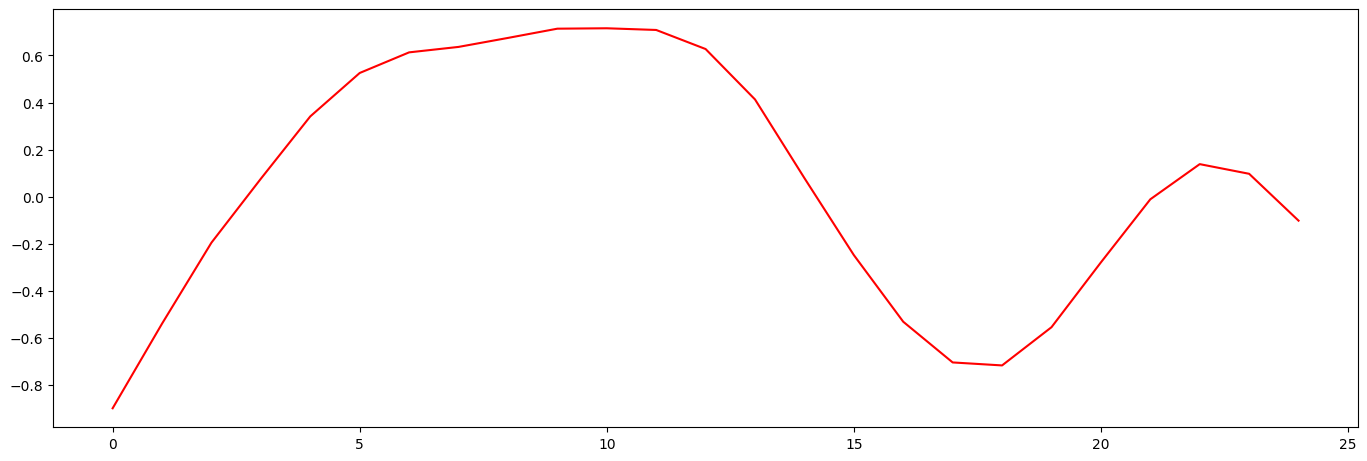

In [55]:
fig, ax = plt.subplots(1,1,figsize = (14,5), sharex=True, sharey= True, layout="tight")
fig.tight_layout(pad=1.9)

start = 4
end = start + 1

lCorHard, stdDev1 = see.PCA_avg(see.intersection(rightChoiceCorrect, see.angSepBins[0]))
rCorHard, std2 = see.PCA_avg(see.intersection(leftChoiceCorrect, see.angSepBins[0]))
rCorMed, std3 = see.PCA_avg(see.intersection(rightChoiceCorrect,see.angSepBins[1]))
lCorMed, std4 = see.PCA_avg(see.intersection(leftChoiceCorrect,see.angSepBins[1]))
lCorEasy, std5 = see.PCA_avg(see.intersection(leftChoiceCorrect, see.angSepBins[2]))
rCorEasy, std6 = see.PCA_avg(see.intersection(rightChoiceCorrect,see.angSepBins[2]))

see.plotWithError(lCorHard, stdDev1, ax, start, end, 'r')
see.plotWithError(rCorHard, std2, ax, start, end, 'r')
see.plotWithError(lCorMed, std4, ax, start, end, 'c')
see.plotWithError(rCorMed, std3, ax, start, end, 'c')
see.plotWithError(lCorEasy, stdDev1, ax, start, end, 'g')
see.plotWithError(rCorEasy, stdDev1, ax, start, end, 'g')

ax.set_title("Left Choice vs Right Choice. By Ang Sep")
ax.set_xlabel("Frame")
ax.set_ylabel("RNN Unit proj onto PCA comp #" + str(start))

plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (14,5), sharex=True, sharey= True, layout="tight")
fig.tight_layout(pad=1.9)

start = 5
end = start + 1

lCorEasy, err1 = see.PCA_avg(see.intersection(leftChoiceCorrect, see.difTrials[0]))
lcorMed, err2 = see.PCA_avg(see.intersection(leftChoiceCorrect, see.difTrials[1]))
rCorEasy, err3 = see.PCA_avg(see.intersection(rightChoiceCorrect,see.difTrials[0]))
rCorMed, err4 = see.PCA_avg(see.intersection(rightChoiceCorrect,see.difTrials[1]))
lCorHard, err5 = see.PCA_avg(see.intersection(leftChoiceCorrect, see.difTrials[2]))
rCorHard, err6 = see.PCA_avg(see.intersection(rightChoiceCorrect,see.difTrials[2]))

see.plotWithError(lCorEasy, err1, ax, start, end, 'g')
see.plotWithError(rCorEasy, err3, ax, start, end, 'g')
see.plotWithError(lCorMed, err2, ax, start, end, 'c')
see.plotWithError(rCorMed, err4, ax, start, end, 'c')
see.plotWithError(lCorHard, err5, ax, start, end, 'r')
see.plotWithError(rCorHard, err6, ax, start, end, 'r')

ax.set_title("Left Choice vs Right Choice. by Diff")


ax.set_xlabel("Frame")

ax.set_ylabel("RNN Unit proj onto PCA comp #" + str(start))


plt.show()

In [58]:
print(len(leftChoiceIncorrect), "trials where left was chosen incorrectly")
print(len(rightChoiceIncorrect), "trials where right was chosen incorrectly")
print("Thus there is an angle bias")

0 trials where left was chosen incorrectly
433 trials where right was chosen incorrectly
Thus there is an angle bias


767 trials where left was chosen incorrectly
4 trials where right was chosen incorrectly
Thus there is an angle bias

In [ ]:
see.plotExplainedVariance()


In [ ]:
#look at how att couples with rnn units next